In [1]:
# flake8: noqa
##########################################################
# Relative Imports
##########################################################
import sys
from os.path import isfile
from os.path import join


def find_pkg(name: str, depth: int):
    if depth <= 0:
        ret = None
    else:
        d = [".."] * depth
        path_parts = d + [name, "__init__.py"]

        if isfile(join(*path_parts)):
            ret = d
        else:
            ret = find_pkg(name, depth - 1)
    return ret


def find_and_ins_syspath(name: str, depth: int):
    path_parts = find_pkg(name, depth)
    if path_parts is None:
        raise RuntimeError("Could not find {}. Try increasing depth.".format(name))
    path = join(*path_parts)
    if path not in sys.path:
        sys.path.insert(0, path)


try:
    import caldera
except ImportError:
    find_and_ins_syspath("caldera", 3)

##########################################################
# Main
##########################################################

import copy
import hydra
from examples.traversals.training import TrainingModule
from examples.traversals.data import DataGenerator, DataConfig
from examples.traversals.configuration import Config
from examples.traversals.configuration.data import Uniform, DiscreteUniform
from typing import TypeVar
from pytorch_lightning import Trainer
from examples.traversals.loggers import logger
from omegaconf import DictConfig, OmegaConf
from rich.panel import Panel
from rich import print
from rich.syntax import Syntax


C = TypeVar("C")


def prime_the_model(model: TrainingModule, config: Config):
    logger.info("Priming the model with data")
    config_copy: DataConfig = copy.deepcopy(config.data)
    config_copy.train.num_graphs = 10
    config_copy.eval.num_graphs = 0
    data_copy = DataGenerator(config_copy, progress_bar=False)
    for a, b in data_copy.train_loader():
        model.model.forward(a, 10)
        break


def print_title():
    print(Panel("Training Example: [red]Traversal", title="[red]caldera"))


def print_model(model: TrainingModule):
    print(Panel("Network", expand=False))
    print(model)


def print_yaml(cfg: Config):
    print(Panel("Configuration", expand=False))
    print(Syntax(OmegaConf.to_yaml(cfg), "yaml"))

# def config_override(cfg: DictConfig):
#     # defaults
#     cfg.hyperparameters.lr = 1e-3
#     cfg.hyperparameters.train_core_processing_steps = 10
#     cfg.hyperparameters.eval_core_processing_steps = 10
#
#     cfg.data.train.num_graphs = 5000
#     cfg.data.train.num_nodes = DiscreteUniform(10, 100)
#     cfg.data.train.density = Uniform(0.01, 0.03)
#     cfg.data.train.path_length = DiscreteUniform(5, 10)
#     cfg.data.train.composition_density = Uniform(0.01, 0.02)
#     cfg.data.train.batch_size = 512
#     cfg.data.train.shuffle = False
#
#     cfg.data.eval.num_graphs = 500
#     cfg.data.eval.num_nodes = DiscreteUniform(10, 100)
#     cfg.data.eval.density = Uniform(0.01, 0.03)
#     cfg.data.eval.path_length = DiscreteUniform(5, 10)
#     cfg.data.eval.composition_density = Uniform(0.01, 0.02)
#     cfg.data.eval.batch_size = "${data.eval.num_graphs}"
#     cfg.data.eval.shuffle = False

# @hydra.main(config_path="conf", config_name="config")
# def main(hydra_cfg: DictConfig):

#     print_title()


#     logger.setLevel(hydra_cfg.log_level)
#     if hydra_cfg.log_level.upper() == 'DEBUG':
#         verbose = True
#     else:
#         verbose = False
#     # really unclear why hydra has so many unclear validation issues with structure configs using ConfigStore
#     # this correctly assigns the correct structured config
#     # and updates from the passed hydra config
#     # annoying... but this resolves all these issues
#     cfg = OmegaConf.structured(Config())
#     cfg.update(hydra_cfg)

#     # debug
#     if verbose:
#         print_yaml(cfg)

#     from pytorch_lightning.loggers import WandbLogger
#     wandb_logger = WandbLogger(project='pytorchlightning')

#     # explicitly convert the DictConfig back to Config object
#     # has the added benefit of performing validation upfront
#     # before any expensive training or logging initiates
#     config = Config.from_dict_config(cfg)

#     # initialize the training module
#     training_module = TrainingModule(config)

#     logger.info("Priming the model with data")
#     prime_the_model(training_module, config)
#     logger.debug(Panel("Model", expand=False))

#     if verbose:
#         print_model(training_module)

#     logger.info("Generating data...")
#     data = DataGenerator(config.data)
#     data.init()

#     logger.info("Beginning training...")
#     trainer = Trainer(gpus=config.gpus, logger=wandb_logger)

#     trainer.fit(
#         training_module,
#         train_dataloader=data.train_loader(),
#         val_dataloaders=data.eval_loader(),
#     )


# if __name__ == "__main__":
#     main()


In [2]:
from examples.traversals.configuration import get_config

config = get_config( as_config_class=True)

data = DataGenerator(config.data)
data.init()

training_module = TrainingModule(config)

logger.info("Priming the model with data")
prime_the_model(training_module, config)

/home/justin/anaconda3/envs/caldera/lib/python3.7/site-packages/omegaconf/omegaconf.py:579: UserWarning: update() merge flag is is not specified, defaulting to False.
For more details, see https://github.com/omry/omegaconf/issues/367
  stacklevel=1,


Output()

Output()

Output()

In [3]:
trainer = Trainer(gpus=config.gpus)

trainer.fit(
    training_module,
    train_dataloader=data.train_loader(),
    val_dataloaders=data.eval_loader(),
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/justin/anaconda3/envs/caldera/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 35 K  
/home/justin/anaconda3/envs/caldera/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/justin/anaconda3/envs/caldera/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/justin/anaconda3/envs/caldera/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

In [5]:
inp, targ = data.eval_loader().first()

In [14]:
from caldera.transforms.networkx import NetworkxAttachNumpyBool

g = targ.to_networkx_list()[0]

to_bool = NetworkxAttachNumpyBool('node', 'features', 'x')
graphs = to_bool(targ.to_networkx_list())
graphs[0].nodes(data=True)

NodeDataView({0: {'features': tensor([1.]), 'x': array([1])}, 1: {'features': tensor([0.]), 'x': array([0])}, 2: {'features': tensor([0.]), 'x': array([0])}, 3: {'features': tensor([0.]), 'x': array([0])}, 4: {'features': tensor([0.]), 'x': array([0])}, 5: {'features': tensor([0.]), 'x': array([0])}, 6: {'features': tensor([0.]), 'x': array([0])}, 7: {'features': tensor([0.]), 'x': array([0])}, 8: {'features': tensor([0.]), 'x': array([0])}, 9: {'features': tensor([0.]), 'x': array([0])}, 10: {'features': tensor([0.]), 'x': array([0])}, 11: {'features': tensor([0.]), 'x': array([0])}, 12: {'features': tensor([0.]), 'x': array([0])}, 13: {'features': tensor([0.]), 'x': array([0])}, 14: {'features': tensor([0.]), 'x': array([0])}, 15: {'features': tensor([0.]), 'x': array([0])}, 16: {'features': tensor([0.]), 'x': array([0])}, 17: {'features': tensor([0.]), 'x': array([0])}, 18: {'features': tensor([0.]), 'x': array([0])}, 19: {'features': tensor([0.]), 'x': array([0])}, 20: {'features':

In [17]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline


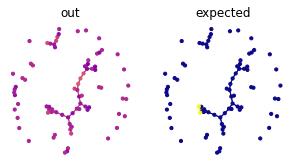

In [25]:
def edge_colors(g, key, cmap):
    edgecolors = list()
    edgelist = list(g.edges)
    edgefeat = list()
    for e in edgelist:
        edata = g.edges[e]
        edgefeat.append(edata[key][0].item())
    edgefeat = np.array(edgefeat)
    edgecolors = cmap(edgefeat)
    return edgecolors
    nx.draw_networkx_edges(g, pos=pos, edge_color=edgecolors, arrows=False)

def node_colors(g, key, cmap):
    nodecolors = list()
    nodelist = list(g.nodes)
    nodefeat = list()
    for n in nodelist:
        ndata = g.nodes[n]
        nodefeat.append(ndata[key][0].item())
    nodefeat = np.array(nodefeat)
    nodecolors = cmap(nodefeat)
    return nodecolors
    nx.draw_networkx_nodes(g, pos=pos, node_size=10, node_color=nodecolors)

def plot_graph(g, ax, cmap, key='features', seed=1):
    pos = nx.layout.spring_layout(g, seed=seed)
    nx.draw_networkx_edges(g, ax=ax, pos=pos, edge_color=edge_colors(g, key, cmap), arrows=False);
    nx.draw_networkx_nodes(g, ax=ax, pos=pos, node_size=10, node_color=node_colors(g, key, cmap))
    
    
def comparison_plot(out_g, expected_g):
    fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
    axes[0].axis('off')
    axes[1].axis('off')
    
    axes[0].set_title("out")
    plot_graph(out_g, axes[0], cm.plasma)
    
    axes[1].set_title("expected")
    plot_graph(expected_g, axes[1], cm.plasma)
    return fig, axes

def validate_compare_plot(trainer, plmodel):
    eval_loader = trainer.val_dataloaders[0]
    for x, y in eval_loader:
        break
    plmodel.eval()
    y_hat = plmodel.model.forward(x, 10)[-1]
    y_graphs = y.to_networkx_list()
    y_hat_graphs = y_hat.to_networkx_list()

    idx = 0
    yg = y_graphs[idx]
    yhg = y_hat_graphs[idx]
    return comparison_plot(yhg, yg)

fig, axes = validate_compare_plot(trainer, training_module)

In [26]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project='pytorchlightning')

In [29]:
wandb_logger.experiment

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/jvrana/pytorchlightning/runs/1s98jp1k

In [39]:
wandb.Image?

Init signature:
wandb.Image(
    data_or_path,
    mode=None,
    caption=None,
    grouping=None,
    boxes=None,
    masks=None,
)
Docstring:     
Wandb class for images.

Args:
    data_or_path (numpy array | string | io): Accepts numpy array of
        image data, or a PIL image. The class attempts to infer
        the data format and converts it.
    mode (string): The PIL mode for an image. Most common are "L", "RGB",
        "RGBA". Full explanation at https://pillow.readthedocs.io/en/4.2.x/handbook/concepts.html#concept-modes.
    caption (string): Label for display of image.
File:           ~/anaconda3/envs/caldera/lib/python3.7/site-packages/wandb/data_types.py
Type:           type
Subclasses:     


In [52]:
import wandb
import io
from PIL import Image
import matplotlib.pyplot as plt

def fig_to_pil(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    im = Image.open(buf)
#     buf.close()
    return im

wandb_logger.experiment.log({'s': [wandb.Image(fig_to_pil(fig))]} )

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [47]:
wandb_logger.experiment.lo

Init signature:
wandb.Image(
    data_or_path,
    mode=None,
    caption=None,
    grouping=None,
    boxes=None,
    masks=None,
)
Docstring:     
Wandb class for images.

Args:
    data_or_path (numpy array | string | io): Accepts numpy array of
        image data, or a PIL image. The class attempts to infer
        the data format and converts it.
    mode (string): The PIL mode for an image. Most common are "L", "RGB",
        "RGBA". Full explanation at https://pillow.readthedocs.io/en/4.2.x/handbook/concepts.html#concept-modes.
    caption (string): Label for display of image.
File:           ~/anaconda3/envs/caldera/lib/python3.7/site-packages/wandb/data_types.py
Type:           type
Subclasses:     


In [44]:
import io
from PIL import Image
import matplotlib.pyplot as plt

buf = io.BytesIO()
fig.savefig(buf, format='png')
buf.seek(0)
im = Image.open(buf)
im.show()
buf.close()

str(buf)

'<_io.BytesIO object at 0x7f7c18d6a410>'

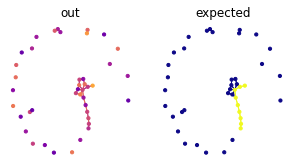

In [124]:
def comparison_plot(out_g, expected_g):
    fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
    axes[0].axis('off')
    axes[1].axis('off')
    
    axes[0].set_title("out")
    plot_graph(out_g, axes[0], cm.plasma)
    
    axes[1].set_title("expected")
    plot_graph(expected_g, axes[1], cm.plasma)
x, y = data.eval_loader().first()
y_hat = training_module.model.forward(x, 10)[-1]
y_graphs = y.to_networkx_list()
y_hat_graphs = y_hat.to_networkx_list()

idx = 0
yg = y_graphs[idx]
yhg = y_hat_graphs[idx]
comparison_plot(yhg, yg)

In [18]:
g = random_graph((100, 150), d=(0.01, 0.03), e=None)


annotate_shortest_path(g)
# nx.draw(g)
pos = nx.layout.spring_layout(g)
nodelist = list(g.nodes)
node_color = []
for n in nodelist:
    node_color.append(g.nodes[n]['target'][0])
edge_list = []
edge_color = []
for n1, n2, edata in g.edges(data=True):
    edge_list.append((n1, n2))
    edge_color.append(edata['target'][0])
print(node_color)
nx.draw_networkx_edges(g, pos=pos, width=0.5, edge_color=edge_color)
nx.draw_networkx_nodes(g, pos=pos, node_color=node_color, node_size=10)


In [10]:
NetworkxAttachNumpyBool?

Init signature:
NetworkxAttachNumpyBool(
    x: str,
    from_key: str,
    to_key: str,
    *,
    default: Any = Ellipsis,
    join_func: str = 'hstack',
    global_key: str = None,
    classes: List[str] = None,
    num_classes: int = None,
)
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Init docstring:
Initialize transform that converts encodes networkx into a boolean represented
 as :class:`np.ndarray` of size 1.

 E.g. `True` gets encoded as `np.ndarray([1.])`

:param x: 'edge', 'node', 'global'
:param from_key: dictionary key to find feature
:param to_key: new key to attach feature
:param default:
:param join_func:
:param global_key:
:param classes:
:param num_classes:
File:           ~/Github/caldera/caldera/transforms/networkx/_nx_attach_np_features.py
Type:           ABCMeta
Subclasses:     


In [19]:
g.nodes(data=True)

NodeDataView({0: {'features': tensor([1.])}, 1: {'features': tensor([0.])}, 2: {'features': tensor([0.])}, 3: {'features': tensor([0.])}, 4: {'features': tensor([0.])}, 5: {'features': tensor([0.])}, 6: {'features': tensor([0.])}, 7: {'features': tensor([0.])}, 8: {'features': tensor([0.])}, 9: {'features': tensor([0.])}, 10: {'features': tensor([0.])}, 11: {'features': tensor([0.])}, 12: {'features': tensor([0.])}, 13: {'features': tensor([0.])}, 14: {'features': tensor([0.])}, 15: {'features': tensor([0.])}, 16: {'features': tensor([0.])}, 17: {'features': tensor([0.])}, 18: {'features': tensor([0.])}, 19: {'features': tensor([0.])}, 20: {'features': tensor([0.])}, 21: {'features': tensor([0.])}, 22: {'features': tensor([0.])}, 23: {'features': tensor([0.])}, 24: {'features': tensor([0.])}, 25: {'features': tensor([0.])}, 26: {'features': tensor([0.])}, 27: {'features': tensor([0.])}, 28: {'features': tensor([0.])}, 29: {'features': tensor([0.])}, 30: {'features': tensor([0.])}, 31: 

In [31]:
from caldera.transforms.networkx import NetworkxApplyToFeature

NetworkxApplyToFeature('features', edge_func= lambda x: list(x))(g)

TypeError: add_edge() argument after ** must be a mapping, not NoneType

In [162]:
import time

from rich.progress import Progress as RichProgress
from contextlib import contextmanager
from dataclasses import dataclass

@dataclass
class TaskEvent:
    task_id: int
    name: str


class TaskProgress(object):
    DEFAULT_REFRESH_PER_SECOND = 4.

    def __init__(self,
                 progress = None,
                 task_id: int = None,
                 refresh_rate_per_second: int = DEFAULT_REFRESH_PER_SECOND,
                 parent = None):
        self.task_id = task_id
        self.children = []
        self.parent = parent
        self.progress = progress or RichProgress()
        self.last_updated = time.time()
        self.refresh_rate_per_second = refresh_rate_per_second

    def self_task(self, *args, **kwargs):
        task_id = self.progress.add_task(*args, **kwargs)
        self.task_id = task_id

    def add_task(self, *args, **kwargs):
        task_id = self.progress.add_task(*args, **kwargs)
        new_task = self.__class__(self.progress, task_id, self.refresh_rate_per_second, parent=self)
        self.children.append(new_task)
        return new_task

    @property
    def _task(self):
        return self.progress.tasks[self.task_id]

    def listen(self, event: TaskEvent):
        if event.name == 'refresh':
            completed = sum(t._task.completed for t in self.children)
            total = sum(t._task.total for t in self.children)
            self.update(completed=completed/total, total=1., refresh=True)
        elif event.name == 'finished':
            self.finish()

    def emit_up(self, event_name):
        if self.parent:
            self.parent.listen(TaskEvent(task_id=self.task_id, name=event_name))

    def emit_down(self, event_name: TaskEvent):
        for child in self.children:
            print("sending to child")
            child.listen(TaskEvent(task_id=self.task_id, name=event_name))

    def update(self, *args, **kwargs):
        now = time.time()
        if 'refresh' not in kwargs:
            if now - self.last_updated > 1. / self.refresh_rate_per_second:
                kwargs['refresh'] = True
            else:
                kwargs['refresh'] = False
                
        if kwargs['refresh']:
            self.emit_up('refresh')
            self.last_updated = now
        self.progress.update(self.task_id, *args, **kwargs)

    def is_complete(self):
        return self.completed >= self.task.total

    def finish(self):
        self.progress.update(self.task_id, completed=self._task.total, refresh=True)
        self.emit_down('finished')

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.progress.__exit__(exc_type, exc_val, exc_tb)
        self.finish()


with TaskProgress() as progress:
    progress.self_task('main', total=10)
    bar1 = progress.add_task('bar1', total=10)
    bar2 = progress.add_task('bar2', total=10)
    for _ in range(10):
        bar1.update(advance=1)
        time.sleep(0.1)
    for _ in range(10):
        bar2.update(advance=1)
        time.sleep(0.1)


Output()

In [62]:
bar.progress.tasks[0].completed

100